<img align="right" width="100" height="100" src="https://jatinangor.itb.ac.id/wp-content/uploads/sites/17/2012/12/Logo-ITB-polos20-1.jpg">

# Seismologi Komputasi - Tugas 3
*Farhan Hamid Lubis - 22319310*<br>
*Rizky Adityo Prastama - 22319311*
***
## Estimasi Traveltime dengan Finite Difference (Hole and Zelt, 1995)
***

### Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(precision = 2)

***
### Pendahuluan

Metode estimasi *traveltime* yang diajukan oleh Vidale memiliki kelemahan jika model yang digunakan memiliki kontras kecepatan. Hole & Zelt pada tahun 1995 mengajukan modifikasi operator Vidale pada bidang batas antara kedua medium dengan perbedaan kecepatan tersebut. Gambar di bawah ini adalah contoh operator Vidale yang dioperasikan terhadap model dua lapisan dengan batas lapisan pada kedalaman 30 km:

<img align = "center" width = 60% src = "img/fd_vidale_mederror.png">

dimana lapisan atas dan bawah memiliki kecepatan masing-masing 3 km/s dan 5 km/s. Terlihat bahwa pada lapisan kedua, kontur *traveltime* tidak bisa ditampilkan. Hal ini disebabkan oleh nilai akar negatif pada operator Vidale. Nilai *traveltime* yang diajukan oleh Vidale dihitung menggunakan persamaan berikut:
$$
t_{3} = t_{0} + \sqrt{2(hs)^{2} - (t_{2} - t_{1})^2}
$$
Pada batas antar lapisan, suku $(t_{2} - t_{1})^{2}$ bernilai lebih besar dari suku $2(hs)^{2}$. Akibatnya, nilai akar negatif membuat nilai $t_{3}$ tidak bisa dihitung sehingga operator Vidale tidak bisa dijalankan pada medium kedua. Hole & Zelt mengatasi masalah pada bidang batas ini dengan menggunakan operator 1D di sepanjang bidang batas. Langkah-langkah metode yang diajukan oleh Hole & Zelt akan dijelaskan pada laporan ini.
***

### Step 1: Input Parameter dan Pembuatan Matriks Offset `x` & Kedalaman `z`

Tahap pertama yang dilakukan adalah memasukkan parameter dari model lapisan yang akan digunakan. Pada tahap ini, input yang diperlukan adalah:
1. Kecepatan lapisan (`v`) dalam km/s. Kecepatan lapisan diurutkan dari lapisan yang lebih dangkal kemudian lapisan yang lebih dalam.
2. Ketebalan lapisan (`v_dz`) dalam km. Diurutkan seperti poin 1.
3. Panjang _cross-section_ (`distance_x`) dalam km.
4. Ukuran grid individu (`h`) dalam km.
5. Lokasi sumber (`source`). Nilai 1 untuk sumber pada pojok kiri atas *cross-section*, 2 untuk sumber di tengah atas *cross-section*, dan 3 untuk sumber di kanan atas *cross-section*.
6. Lokasi *receiver* (`r_offset`) dalam km.

Berdasarkan input yang diberikan, program akan secara otomatis membuat matriks offset `x` dan matriks kedalaman `z`. Ukuran matriks `x` dan `z` ditentukan oleh total ketebalan lapisan, panjang *cross-section*, serta ukuran grid individu. Semakin besar ukuran grid individu, semakin kecil ukuran matriks `x` dan `z` begitu pula sebaliknya.

Pada tahap akhir, akan ada visualisasi *raypath*. Oleh karena itu, untuk metode ini, posisi source ditentukan pada pojok kiri atas (0, 0) dari *cross-section*.

In [2]:
v = np.array([3.0, 8.0]) # kecepatan lapisan  (km/s)
v_dz = np.array([40, 60]) # ketebalan lapisan (km)
layers = len(v)

distance_x = 150 # km
distance_z = np.sum(v_dz)
h = 0.1 # grid spacing

grid_x = int(np.round((distance_x / h) + 1))
grid_z = int(np.round((distance_z / h) + 1))
grid = np.zeros([grid_z, grid_x])

source_x = 0
source_z = 0
    
# lokasi receiver pada cross-section
r_z = 0
r_offset = 140 # km
r_x = int(np.round(r_offset / h, decimals = 0))

# matriks offset dan kedalaman berdasarkan input yang diberikan
x = np.arange(0, np.round(distance_x + h, decimals = 2), h)
z = np.arange(0, np.round(distance_z + h, decimals = 2), h)
x, z = np.meshgrid(x, z)

***
### Step 2: Membuat Matriks *Slowness* dan Perhitungan Sudut Kritis

Ukuran matriks `slowness` yang dibuat akan mengikuti ukuran dari matriks offset `x` dan matriks kedalaman `z`. Matriks *slowness* akan digunakan sebagai informasi kelambanan medium di setiap titik grid.

Sudut kritis untuk fenomena refraksi dapat dihitung menggunakan hukum Snell sebagai berikut:
$$
u_{1}\sin{\theta_{c}} = u_{2}\sin{\theta_{2}}\\
\sin{\theta_{c}} = \frac{u_{2}}{u_{1}}\sin{\theta_{2}}
$$
dimana $u$ adalah *slowness*. Karena sudut refraksi $\theta_{2}$ adalah $90^{\circ}$, maka
$$
\sin{\theta_{c}} = \frac{u_{2}}{u_{1}}\\
\theta_{c} = \sin^{-1}{\frac{u_{2}}{u_{1}}}
$$
Nilai sudut kritis (dalam derajat) disimpan dalam variabel `crit_angle` sementara offset kritis pada bidang batas disimpan dalam variabel `crit_offset`.

In [3]:
v_z = np.zeros([1, layers + 1])
for i in range(1, layers + 1):
    v_z[0, i] = v_z[0, i - 1] + v_dz[i - 1]

v_grid = v_z / h

velo = np.zeros([grid_z, grid_x])

for j in range(np.shape(velo)[1]):
    for k in range(layers):
        for i in range(int(np.round(v_grid[0, k])), int(np.round(v_grid[0, k + 1]))):
            velo[i, j] = v[k]
            velo[i + 1, j] = v[k]

slowness = 1 / velo

if v[0] != v[1]:
    slowness_upper = 1 / v[0]
    slowness_lower = 1 / v[1]
    crit_angle = np.rad2deg(np.arcsin(slowness_lower / slowness_upper))
    crit_offset = np.round(v_dz[0] * np.tan(np.deg2rad(crit_angle)), decimals = 1)
    crit_gridx = int(np.round(crit_offset / h, decimals = 0))
    crit_gridz = int(v_grid[0, 1])
else:
    pass

***
### Step 3: Estimasi *Traveltime*

**Arah Vertikal dan Lateral**

Tidak terdapat perbedaan untuk menghitung nilai *traveltime* pada arah vertikal dan lateral. Perhitungan tersebut menggunakan persamaan berikut:
$$
t_{i} = \frac{h}{2} \left(s_{i} + s_{A}\right)
$$

In [4]:
t = np.zeros([grid_z, grid_x])
t[int(source_z), int(source_x)] = 0

# Perambatan lateral dari sumber
# Arah kiri
for i in reversed(range(0, int(source_x))):
    t[int(source_z), i] = t[int(source_z), i + 1] + ((h / 2) * (slowness[int(source_z), i] + slowness[int(source_z), i + 1]))
# Arah kanan
for i in range(int(source_x) + 1, grid_x):
    t[int(source_z), i] = t[int(source_z), i - 1] + ((h / 2) * (slowness[int(source_z), i] + slowness[int(source_z), i - 1]))

# Perambatan vertikal dari sumber
# Arah atas
for i in reversed(range(0, int(source_z))):
    t[i, int(source_x)] = t[i + 1, int(source_x)] + ((h / 2) * (slowness[i, int(source_x)] + slowness[i + 1, int(source_x)]))
# Arah bawah
for i in range(int(source_z) + 1, grid_z):
    t[i, int(source_x)] = t[i - 1, int(source_x)] + ((h / 2) * (slowness[i, int(source_x)] + slowness[i - 1, int(source_x)]))

**Arah Diagonal**

Perbaikan yang diajukan oleh Hole & Zelt berpengaruh terhadap perhitungan arah diagonal. Hole & Zelt membagi tiga tahap perhitungan sebagai berikut:
1. Perhitungan *direct wave* atau gelombang langsung pada lapisan pertama.
2. Perhitungan *critically refracted head wave* atau gelombang muka refraksi kritis pada bidang batas.
3. Perhitungan *refracted wave* atau gelombang refraksi pada lapisan kedua.

**Tahap 1** masih mengikuti operator Vidale 2D untuk mengestimasi nilai *traveltime*. Persamaan Vidale adalah sebagai berikut:
$$
t_{3} = t_{0} + \sqrt{2(hs)^{2} - (t_{2} - t_{1})^2}
$$

In [5]:
for i in range(int(source_x) + 1, grid_x):
    for j in range(int(source_z) + 1, crit_gridz):
        t[j, i] = t[j - 1, i - 1] + np.sqrt(2 * (h * slowness[j, i])**(2) - (t[j - 1, i] - t[j, i - 1])**(2))

<img align = "center" width = 60% src = "img/loop_headwave.png">

**Tahap 2** merupakan tahap yang krusial dalam perbaikan estimasi *traveltime* yang diajukan oleh Hole & Zelt. Gelombang muka kritis terjadi pada daerah di atas offset kritis. Pada daerah ini, nilai *traveltime* pada matriks `t` harus diperbaiki. Pertama, di sepanjang bidang batas, nilai `t` dihitung kembali secara lateral menggunakan operator 1D berikut:
$$
t_{0} = t_{1} + hs
$$
dimana $t_{0}$ adalah waktu pada grid yang dihitung kembali, $t_{1}$ adalah waktu pada grid acuan, $h$ adalah ukuran grid individu, dan $s$ adalah nilai *slowness* lapisan dengan kecepatan yang lebih tinggi (lapisan kedua). Jika nilai $t_{0}$ lebih kecil dari $t$ yang sudah dihitung pada tahap 1, maka nilai $t_{0}$ menggantikan nilai yang sudah ada tersebut. Jika $t_{0}$ lebih besar, maka nilai $t$ hasil perhitungan pada tahap 1 tidak diubah.

Setelah koreksi arah lateral, koreksi arah vertikal dari batas bidang ke arah permukaan dilakukan menggunakan operator 1D yang sama, namun menggunakan *slowness* lapisan pertama. Sama seperti pada bidang batas, jika $t_{0}$ yang diperoleh lebih kecil dari nilai $t$ yang sudah ada, maka nilai $t_{0}$ tersebut menggantikan nilai $t$. Begitu pula sebaliknya.

In [6]:
for i in range(crit_gridx, grid_x):
    t_hw = t[crit_gridz - 1, i - 1] + h * slowness[crit_gridz, i]
    if t_hw < t[crit_gridz - 1, i]:
        t[crit_gridz - 1, i] = t_hw
    else:
        pass
    for j in reversed(range(0, crit_gridz - 1)):
        t_hw = t[j + 1, i] + h * slowness[j, i]
        if t_hw < t[j, i]:
            t[j, i] = t_hw
        else:
            pass

**Tahap 3** merupakan estimasi *traveltime* menggunakan operator 2D Vidale pada medium kedua. Setelah nilai `t` pada bidang batas diperbaiki, nilai `t` pada bagian atas lapisan kedua dihitung menggunakan operator 1D ($t_{0} = t_{1} + hs$) ke arah bawah dari bagian bawah lapisan pertama. Setelah itu, operator 2D digunakan secara normal mengikuti persamaan:
$$
t_{3} = t_{0} + \sqrt{2(hs)^{2} - (t_{2} - t_{1})^2}
$$

In [7]:
for i in range(crit_gridz, grid_z):
    t[i, int(source_x)] = t[i - 1, int(source_x)] + h * slowness[i, int(source_x)]

for i in range(int(source_x) + 1, grid_x):
    t[crit_gridz, i] = t[crit_gridz - 1, i] + h * slowness[crit_gridz, i]
    for j in range(crit_gridz, grid_z):
        t[j, i] = t[j - 1, i - 1] + np.sqrt(2 * (h * slowness[j, i])**(2) - (t[j - 1, i] - t[j, i - 1])**(2))

***
### Step 4: Visualisasi *Raypath*

*Raypath* ditampilkan sebagai jalur gelombang dari sumber ke *receiver* dengan nilai `t` terkecil.

In [8]:
ray_x = np.array([x[int(r_z), int(r_x)]])
ray_z = np.array([z[int(r_z), int(r_x)]])

ref_crit_up_x = r_offset - crit_offset

ray_x = np.append(np.append(np.append(ray_x, ref_crit_up_x), crit_offset), source_x)
ray_z = np.append(np.append(np.append(ray_z, v_dz[0]), v_dz[0]), source_z)

***
### Step 5: Plot Kontur Traveltime dan *Raypath*

Tahap ini merupakan pembuatan kontur dengan informasi berikut:
1. Matriks `x` sebagai informasi offset setiap grid
2. Matriks `z` sebagai informasi kedalaman setiap grid
3. Matriks `t` sebagai informasi *traveltime* setiap grid
4. `ray_x` sebagai informasi offset dari *raypath*
5. `ray_z` sebagai informasi kedalaman dari *raypath*

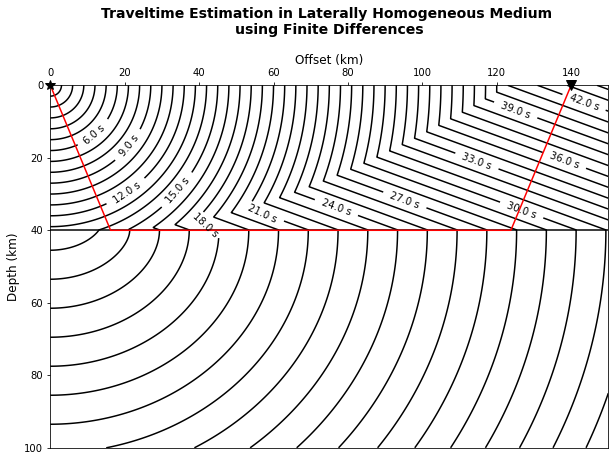

In [9]:
steps = 1
max_lvl = np.round(np.amax(t))
lvl = np.arange(0, max_lvl + steps, steps)
label_lvl = np.arange(0, max_lvl + steps, steps + 2)

fig, ax = plt.subplots()
cs = ax.contour(x, z, t, levels = lvl, colors = 'k')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_title("Traveltime Estimation in Laterally Homogeneous Medium \nusing Finite Differences", pad = 20, fontdict = {'fontsize': 14, 'fontweight': 'bold'})
ax.set_xlabel("Offset (km)", fontdict = {'fontsize': 12, 'fontweight': 'medium'})
ax.set_ylabel("Depth (km)", fontdict = {'fontsize': 12, 'fontweight': 'medium'})

fgz_scale = 10 # inches
fgz_x = (grid_x / max(grid_x, grid_z)) * fgz_scale
fgz_z = (grid_z / max(grid_x, grid_z)) * fgz_scale
fig.set_size_inches(fgz_x, fgz_z)

plt.gca().invert_yaxis()
plt.hlines(v_dz[0], 0, distance_x, colors = 'k')
plt.plot(ray_x, ray_z, 'r')
source = plt.plot(source_x, source_z, 'k', marker = '*', markersize = '10')[0]
source.set_clip_on(False)
receiver = plt.plot(r_offset, r_z, 'k', marker = 'v', markersize = '10')[0]
receiver.set_clip_on(False)

ax.clabel(cs, levels = label_lvl, inline=True, fontsize = '10', inline_spacing=5, fmt='%1.1f s')
plt.show()